# Advance Lane Lines

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import useful packages

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
%matplotlib inline

## Calibrating Camera

In [23]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

nx = 9
ny = 6

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    print('processing image ' + fname)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
    else:
        print('No corner found')
        

print("Prcoess camera cal image done")


processing image camera_cal/calibration1.jpg
No corner found
processing image camera_cal/calibration10.jpg
processing image camera_cal/calibration11.jpg
processing image camera_cal/calibration12.jpg
processing image camera_cal/calibration13.jpg
processing image camera_cal/calibration14.jpg
processing image camera_cal/calibration15.jpg
processing image camera_cal/calibration16.jpg
processing image camera_cal/calibration17.jpg
processing image camera_cal/calibration18.jpg
processing image camera_cal/calibration19.jpg
processing image camera_cal/calibration2.jpg
processing image camera_cal/calibration20.jpg
processing image camera_cal/calibration3.jpg
processing image camera_cal/calibration4.jpg
No corner found
processing image camera_cal/calibration5.jpg
No corner found
processing image camera_cal/calibration6.jpg
processing image camera_cal/calibration7.jpg
processing image camera_cal/calibration8.jpg
processing image camera_cal/calibration9.jpg
Prcoess camera cal image done


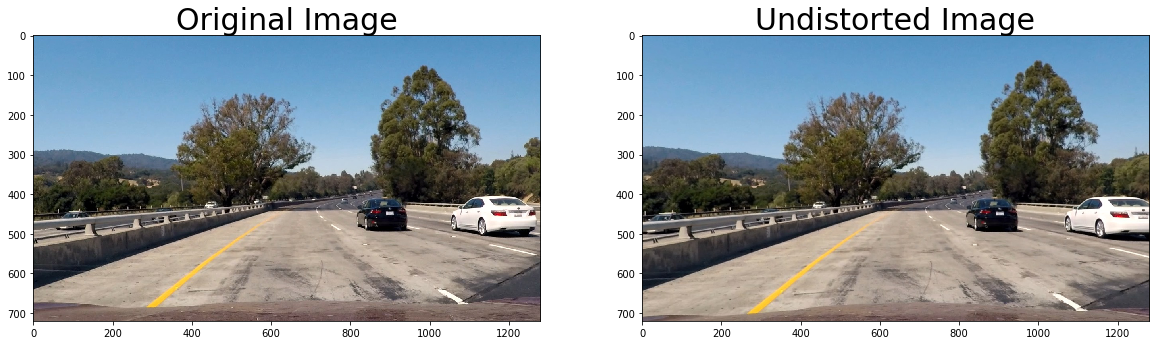

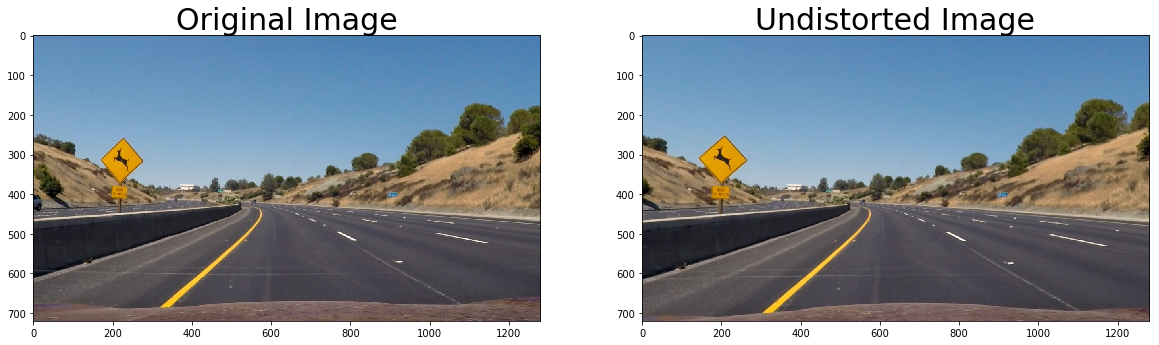

In [33]:

def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def display_image(img, dst):
    dst_display = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_display)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst_display)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()
    
def process_image(fname, objpoints, imgpoints):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    dst = cal_undistort(img, objpoints, imgpoints)
    display_image(img,dst)

process_image('test_images/test1.jpg', objpoints, imgpoints)

process_image('test_images/test2.jpg', objpoints, imgpoints)


